# An Introduction to Graph Neural Networks

By Payal Chandak, on 20 June 2020
<br> <br>
Graphs in the real world, such as social networks, chemical molecules and biological knowledge graphs, are rich with information that cannot be found in individual entities. A method for learning graph representations or node classification would be extremely valuable. Unfortunately, the modern deep learning toolbox is designed for grids (ie. images) and simple sequences (ie. text). CNNs and RNNs cannot generalize to graphs that have arbitrary size, complex topological structures and no fixed node ordering. Graph neural networks (GNN) provide a powerful tool to learn representations from any arbitrary graph structure by leveraging local network neighborhoods. This tutorial aims to (1) introduce the concept of graph neural networks, (2) discuss the quatitative motivation behind different GNN architectures and (3) implement these architectures using the PyTorch Geometric library. 
<br> <br>

In [1]:
from IPython.lib.display import YouTubeVideo

import numpy as np

import torch 
import torch.nn as nn
import torch.optim as optim

from torch_geometric.data import Data, GraphSAINTRandomWalkSampler
from torch_geometric.datasets import Planetoid, Entities
from torch_geometric.nn import GCNConv, RGCNConv, GATConv, SAGEConv, JumpingKnowledge, GINConv, DeepGraphInfomax

torch.manual_seed(200620)
np.random.seed(200620)

## What is a Graph Neural Network? 

Graph neural networks have a somewhat universal architecture where forward propagation uses a 'neighborhood aggregation' technique. The model iteratively produces new feature representations for a given node by aggregating the current feature representations of its adjacent nodes’ (ie. neighbors) and the node itself. Here, an iteration is parametrized by a layer of the neural network. This means that the computational graph of the neural network is defined by the neighborhood of each node. And, each layer in the graph neural network can be thought of as a step where each node aggregates messages from its neighboring nodes, as visualized by Microsoft in this [video](https://www.youtube.com/watch?v=cWIeTMklzNg):

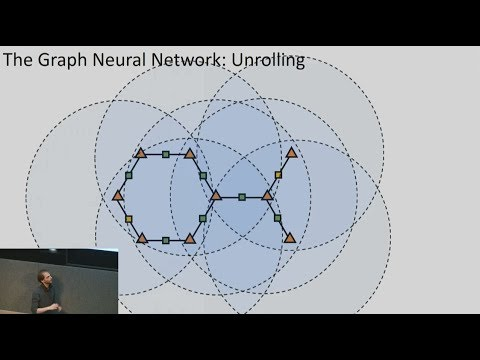

In [2]:
YouTubeVideo('cWIeTMklzNg', height=500, width=890, start=70, end=460)

We have a graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ described by an adjacency matrix $A$. The goal is to learn a function of node input features for node classification. The model takes as input a feature descriptions summarized by matrix $X$ which is $N \times D$ ($N$: number of nodes, $D$: number of input features) and produces a node-level output $Z$ (a $N \times C$ feature matrix, where $C$ is the number of classes per node). At the node level, each layer of the GNN is doing neighborhood aggregation to transform the node representation. At the graph level, every neural network layer can then be written as a non-linear function $f$: 
<br><br>$$H^{(l+1)}=f^{(l+1)}(H^{(l)},A)$$<br>
with $H^{(0)}=X$ and $H^{(L)}=Z$, where L is the number of layers. Notice that each node started with an input vector of length $D$ and ended at a classification vector of length $C$, where $D$ need not equal $C$. This is possible because after doing neighborhood aggregation, $f$ applies a non-linear transformation to node representations using its parameters, a weight matrix $W$ and an activation $\sigma$. The dimension of node representations will change from one layer to another when $W$ is not a square matrix. Note that each layer learns it's own parameters. The specific GNN architechtures then differ only in how $f(⋅,⋅)$ is chosen and parameterized. 

## GNN Architectures


In recent years, many architectures of graph neural networks have been introduced. I will explore the quantitative motivations behind some of the most influential architectures in the field. I will also implement simple models using these architectures in PyTorch and evaluate them on the benchmark Cora dataset. 



### Dataset

In [3]:
print('For this tutorial, we will use a standard citation dataset that is commonly used to benchmark GNN performance.')
print('The Cora dataset is a homogeneous, undirected graph where nodes are publications linked by citations.')
dataset = Planetoid(root='/tmp/Cora', name='Cora', split='full')
print('It contains:')
graph = dataset[0]
print('\t- {:d} labels'.format(dataset.num_classes))
print('\t- {:d} nodes'.format(graph.num_nodes))
print('\t- {:d} training'.format(graph.train_mask.sum().item()))
print('\t- {:d} validation'.format(graph.val_mask.sum().item()))
print('\t- {:d} testing'.format(graph.test_mask.sum().item()))

For this tutorial, we will use a standard citation dataset that is commonly used to benchmark GNN performance.
The Cora dataset is a homogeneous, undirected graph where nodes are publications linked by citations.
It contains:
	- 7 labels
	- 2708 nodes
	- 1208 training
	- 500 validation
	- 1000 testing


### Tools for Learning

#### Hyperparameters

In [4]:
class Hyperparameters():
    def __init__(self):
        self.num_node_features = None
        self.num_classes = None
        self.lr = 0.005
        self.w_decay = 5e-4   
        self.dropout = 0.3
        self.epochs = 200                
        self.cuda = True                
        self.device  =  None    

args = Hyperparameters()
args.num_node_features = graph.num_node_features
args.num_classes = dataset.num_classes
args.cuda = args.cuda and torch.cuda.is_available() 
if args.cuda:
    args.device = torch.device('cuda:2') 
else:
    args.device = torch.device('cpu')

#### Supervised learning

The `LearnGraph`class can train an arbitrary GNN on an arbitrary graph for node classification. By default, binary cross entropy loss and adam optimizer are used. 

In [5]:
class LearnGraph(): 
    
    def __init__(self, graph, model, args, criterion=None):
        self.args = args
        self.graph = graph.to(self.args.device)
        self.model = model.to(self.args.device)
        
        if not criterion: 
            criterion = nn.CrossEntropyLoss()
        self.criterion = criterion
        
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.args.lr, weight_decay=self.args.w_decay)
        
        self.train_loss = []
        self.val_loss = []
        self.train_complete = False 
        
    def learn(self) -> None:
        # tracks training and validation loss over epochs
        # can add early stopping mechanism by comparing losses
        for epoch in range(self.args.epochs): 
            if self.train_complete: return
            
            tl = self.train_epoch()
            self.train_loss.append(tl)
            
            vl = self.val()
            self.val_loss.append(vl)
                
        self.train_complete = True
        
    def train_epoch(self) -> float:
        # trains a single epoch (ie. one pass over the full graph) and updates the models parameters
        # returns the loss
        self.model.train()
        labels = self.graph.y[self.graph.train_mask]
        self.optim.zero_grad()
        output = self.model.forward(self.graph) 
        loss = self.criterion(output[self.graph.train_mask], labels)
        loss.backward()
        self.optim.step()
        return loss.data.item()
    
    def val(self) -> float:
        # returns the validation loss 
        self.model.eval()
        labels = self.graph.y[self.graph.val_mask]
        output = self.model.forward(self.graph) 
        loss = self.criterion(output[self.graph.val_mask], labels)
        return loss.data.item()
    
    def test(self) -> float: 
        # returns the test accuracy 
        if not self.train_complete: 
            self.learn()
        self.model.eval()
        labels = self.graph.y[self.graph.test_mask]    
        _, pred = self.model.forward(self.graph).max(dim=1)
        correct = float ( pred[self.graph.test_mask].eq(labels).sum().item() )
        acc = correct / self.graph.test_mask.sum().item()
        return acc
        


### Graph Convolutional Networks

**[GCNConv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv)** from Kipf and Welling: [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907) (ICLR 2017)
Also see [this blog by Kipf](http://tkipf.github.io/graph-convolutional-networks/) 
<br> <br> 
The basic propagation rule is $$f: \sigma\left(A H^{(l)} W^{(l)}\right)$$  
According to the adjacency matrix, we sum the feature vectors of all neighboring nodes but not the node itself. We fix this by enforcing self-loops: $\hat{A} = A + I$
Another limitation is that $\hat{A}$ is not normalized, so multiplication with $\hat{A}$ will completely change the scale of the feature vectors. Let $\hat{D}$ be the diagonal node degree matrix. Simple normalization involves using $\hat{D}^{-1} \hat{A} \text{ instead of } \hat{A}$. In practice, we do symmetric normalization such that the final propagation rule is <br><br> 
$$f: \sigma\left(\hat{D}^{-\frac{1}{2}} \hat{A} \hat{D}^{-\frac{1}{2}} H^{(l)} W^{(l)}\right)$$<br> 
For a given node $i$ feature vector, where $ N_{i}$ is its neighborhood and $c_{i j}$ is a normalization constant for the edge $(i, j)$, the update is:  <br> <br> 
$$h_{i}^{(l+1)}=\sigma\ \left(\ \sum_{j \ \in \ N_{i}} \frac{1}{c_{i j}} \ h_{j}^{(l)} \ W^{(l)}\ \right)$$<br> 



In [6]:
class GNN(torch.nn.Module):
    def __init__(self): 
        super(GNN, self).__init__()
        self.conv1 = GCNConv(args.num_node_features, 64)
        self.conv2 = GCNConv(64, args.num_classes)
        self.transition = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(p=args.dropout)
        )

    def forward(self, graph): 
        x, edge_index = graph.x, graph.edge_index
        x = self.conv1(x, edge_index)
        x = self.transition(x)
        x = self.conv2(x, edge_index)
        return x

learner = LearnGraph(model=GNN(), graph=graph, args=args)
acc = learner.test()
print('Accuracy: {:.1%}'.format(acc))

Accuracy: 85.9%


### Relational Graph Convolutional Networks

**[RGCNConv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.RGCNConv)** from Schlichtkrull *et al.*: [Modeling Relational Data with Graph Convolutional Networks](https://arxiv.org/abs/1703.06103) (ESWC 2018)
<br> <br> 
'Knowledge' graphs have nodes connected by many different relationships. To capture many types of links in graphs, we can apply relation-specific transformations on incoming messages. For a specific node $i$, $\mathcal{N}_{i}^{r}$ contains its neighbors connected by link $r$. $c_{i, r}$ is a normalization constant (such as $|\mathcal{N}_{i}^{r}|$). 
<br> <br>  $$h_{i}^{(l+1)}=\sigma\left(\ \sum_{r \ \in \ \mathcal{R}} \  \sum_{j \ \in \ \mathcal{N}_{i}^{r}} \frac{1}{c_{i, r}} \ W_{r}^{(l)}  h_{j}^{(l)}+W_{0}^{(l)} h_{i}^{(l)}\right)$$<br> 
The parameters of the network grow rapidly with the number of relations in the graph. We need regularlization to prevent overfitting on rare relations. Using basis decompostion, each $W_{r}^{(l)}$ is defined as a linear combination of basis vectors $V_{b}^{(l)} \in \mathbb{R}^{d^{(l+1)} \times d^{(l)}}$, the space of $W_{r}^{(l)}$. Only the coefficients $a_{r b}^{(l)}$ depend on $r$. This method alleviates overfitting by creating weight sharing across frequent and rare relations. 
<br> <br> $$W_{r}^{(l)}=\sum_{b=1}^{B} a_{r b}^{(l)} V_{b}^{(l)}$$<br> 
Since R-GCN is applied to heterogenous graphs, we will use the MUTAG graph instead of Cora. RGCN auto-generates unique embeddings as input features for nodes if no features are provided, as in MUTAG. Minor changes made to `LearnGraph`to accomodate MUTAG. 

In [7]:
mutag_dataset = Entities(root='/tmp/MUTAG', name='MUTAG')
mutag_graph = mutag_dataset[0]

class LearnMUTAG(): 
    
    def __init__(self, graph, model, args, criterion=None):
        self.args = args
        self.graph = graph.to(self.args.device)
        self.model = model.to(self.args.device)
        
        if not criterion: 
            criterion = nn.CrossEntropyLoss()
        self.criterion = criterion
        
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.args.lr, weight_decay=self.args.w_decay)
        
        self.train_loss = []
        self.train_complete = False 
        
    def learn(self) -> None:
        for epoch in range(self.args.epochs): 
            if self.train_complete: return
            tl = self.train_epoch()
            self.train_loss.append(tl)
        self.train_complete = True
        
    def train_epoch(self) -> float:
        self.model.train()
        labels = self.graph.train_y
        self.optim.zero_grad()
        output = self.model.forward(self.graph) 
        loss = self.criterion(output[self.graph.train_idx], labels)
        loss.backward()
        self.optim.step()
        return loss.data.item()
    
    def test(self) -> float: 
        # returns the test accuracy 
        if not self.train_complete: 
            self.learn()
        self.model.eval()
        labels = self.graph.test_y
        _, pred = self.model.forward(self.graph).max(dim=1)
        correct = float ( pred[self.graph.test_idx].eq(labels).sum().item() )
        acc = correct / len(self.graph.test_idx)
        return acc
    
class GNN(torch.nn.Module):
    def __init__(self): 
        super(GNN, self).__init__()
        self.conv1 = RGCNConv(mutag_graph.num_nodes, 16, mutag_dataset.num_relations, num_bases=30)
        self.conv2 = RGCNConv(16, mutag_dataset.num_classes, mutag_dataset.num_relations, num_bases=30)
        self.transition = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(p=args.dropout)
        )

    def forward(self, graph): 
        x, edge_index, edge_type = graph.x, graph.edge_index, graph.edge_type
        x = self.conv1(x, edge_index, edge_type)
        x = self.transition(x)
        x = self.conv2(x, edge_index, edge_type)
        return x

learner = LearnMUTAG(model=GNN(), graph=mutag_graph, args=args)
acc = learner.test()
print('Accuracy: {:.1%}'.format(acc))

Accuracy: 72.1%


### Graph Attention Networks

**[GATConv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GATConv)** from Veličković *et al.*: [Graph Attention Networks](https://arxiv.org/abs/1710.10903) (ICLR 2018)
<br> <br> 
GATConv is inspired by the use of self-attention (Google transformer) which has achieved SOTA performance in NLP. The idea is that nodes can 'attend' over their neighbors and select the direction from which they recieve information. For a single layer, where nodes go from $F$ to $F^{\prime}$ features, the following steps are applied: 

1. Linear transformation of input features using a weight matrix, $\mathbf{W} \in \mathbb{R}^{F^{\prime} \times F}$

2. Compute attention coefficients $e_{i j} \in \mathbb{R}$ for each node pair $(i, j)$ using a shared attention mechanism $a$. Here this mechanism is a single-layer feedforward network network with a the parameter vector, $\overrightarrow{\mathbf{a}} \in \mathbb{R}^{2 F^{\prime}}$
<br> <br>$$e_{i j}=a\left(\mathbf{W} \vec{h}_{i}, \mathbf{W} \vec{h}_{j}\right) = \text{LeakyReLU}\left(\overrightarrow{\mathbf{a}}^{T}\left[\mathbf{W} \vec{h}_{i} \| \mathbf{W} \vec{h}_{j}\right]\right)$$ <br>

3. Normalize attention coefficients across nodes: $\alpha_{i j}=\operatorname{softmax}_{j}\left(e_{i j}\right)$ 

4. Compute output features as a linear combination of input features corresponding to their normalized attention coefficients 
<br> <br> $$\vec{h}_{i}^{\prime}=\sigma\left(\sum_{j \in \mathcal{N}_{i}} \alpha_{i j} \mathbf{W} \vec{h}_{j}\right)$$ <br>
5. This process can be stabilized using multi-head attention, which concatenates/averages multiple indepedently computed output features from independent attention layers <br> <br>



In [8]:
class GNN(torch.nn.Module):
    def __init__(self): 
        super(GNN, self).__init__()
        self.conv1 = GATConv(args.num_node_features, 8, heads=8)
        self.conv2 = GATConv(64, args.num_classes, heads=1)
        self.transition = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(p=args.dropout)
        )

    def forward(self, graph): 
        x, edge_index = graph.x, graph.edge_index
        x = self.conv1(x, edge_index)
        x = self.transition(x)
        x = self.conv2(x, edge_index)
        return x

learner = LearnGraph(model=GNN(), graph=graph, args=args)
acc = learner.test()
print('Accuracy: {:.1%}'.format(acc))

Accuracy: 85.2%


### GraphSAGE

**[SAGEConv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.SAGEConv)** from Hamilton *et al.*: [Inductive Representation Learning on Large Graphs](https://arxiv.org/abs/1706.02216) (NIPS 2017)
<br> <br> 
GraphSAGE generalizes GCN to use trainable aggregation functions beyond simple convolutions. For a given layer $(l+1)$, at each node $i$, the embeddings $h_{j}^{(l)}$ for all nodes $j$ in its neighborhood $\mathcal{N}(i)$ are combined into a single vector $h^{(l+1)}_{\mathcal{N}(i)}$ using an aggregation function. Aggregating the neighborhood separately from the node itself implictly adds skip connections across layers.
<br> <br> $$\mathbf{h}_{\mathcal{N}(i)}^{(l+1)} = \operatorname{AGGREGATE}_{(l+1)}\left(\left\{\mathbf{h}_{j}^{(l)}, \forall j \in \mathcal{N}(i)\right\}\right)$$  <br>
Aggregation functions can include mean (~traditional GCN), LSTM and Pooling. In max pooling, each neighbor vector is fed through a single-layer neural network and then an elementwise max-pooling operation is applied. Max pooling implicitly selects the important nodes, much like Graph Attention Networks.
<br> <br> $$\mathrm{AGGREGATE}_{(l+1)}^{\mathrm{pool}}=\max \left(\left\{\sigma\left(\mathbf{W}_{\mathrm{pool}} \ \mathbf{h}_{j}^{(l+1)}+\mathbf{b}\right), \forall j \in \mathcal{N}(i)\right\}\right)$$ <br>
The final step is to concatenate the node's current representation $h^{(l)}_{i}$ with the aggregated neighborhood vector $h^{(l+1)}_{\mathcal{N}(i)}$. This concatenated vector is fed through a single-layer neural network to calculate the output representation $h^{(l+1)}_{i}$
<br> <br> $$\mathbf{h}_{i}^{(l+1)} = \sigma \left(W_{(l+1)} \left[\ h^{(l)}_{i} \  \| \  h^{(l+1)}_{\mathcal{N}(i)}\ \right] \right)$$ <br>


In [9]:
class GNN(torch.nn.Module):
    def __init__(self): 
        super(GNN, self).__init__()
        self.conv1 = SAGEConv(args.num_node_features, 64, normalize=True)
        self.conv1.aggr = 'max'
        self.conv2 = SAGEConv(64, args.num_classes,  normalize=True)
        self.conv2.aggr = 'max'
        self.transition = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(p=args.dropout)
        )
        print()

    def forward(self, graph): 
        x, edge_index = graph.x, graph.edge_index
        x = self.conv1(x, edge_index)
        x = self.transition(x)
        x = self.conv2(x, edge_index)
        return x

learner = LearnGraph(model=GNN(), graph=graph, args=args)
acc = learner.test()
print('Accuracy: {:.1%}'.format(acc))


Accuracy: 85.1%


### Jumping Knowledge Networks

**[Jumping Knowledge](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.models.JumpingKnowledge)** from Xu *et al.*: [Representation Learning on Graphs with Jumping Knowledge Networks](https://arxiv.org/abs/1806.03536) (ICML 2018)
<br> <br>
Many aggregation based models achieve best performance with 2 layer networks. After that, performance degrades despite theoretically greater access to information and even after adding residual connections. In biological networks, the majority of the nodes have few connections, whereas some nodes are hubs. In the same graph, the same number of GNN layers an lead to very different effects for different nodes. 
<br> <br>
Unlike GAT or GraphSAGE which select the direction of expansion, Jumping Knowledge operates on the locality of expansion. This model proposes two architectural changes – jump connections and a subsequent selective but adaptive aggregation mechanism. As in common neighborhood aggregation networks, each layer increases the size of the influence distribution by aggregating neighborhoods from the previous layer. In the last JK layer, for each node, we select from all of those intermediate representations. If this is done independently for each node, then the model can adapt the effective neighborhood size for each node as needed, resulting in exactly the desired adaptivity. The layer aggregation mechanisms can include concatenation, max pooling, and lstm attention. 
<br> <br>

In [10]:
class GNN(torch.nn.Module):
    def __init__(self): 
        super(GNN, self).__init__()
        self.conv1 = GCNConv(args.num_node_features, 64)
        self.convx= GCNConv(64, 64)
        self.jk = JumpingKnowledge(mode='max')
        self.final = nn.Linear(64, args.num_classes)
        self.transition = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(p=args.dropout)
        )

    def forward(self, graph): 
        x, edge_index = graph.x, graph.edge_index
        xs = []
        x = self.conv1(x, edge_index)
        x = self.transition(x)
        xs.append(x)
        for _ in range(5): 
            x = self.convx(x, edge_index)
            x = self.transition(x)
            xs.append(x)
        x = self.jk(xs)
        x = self.final(x)
        return x

learner = LearnGraph(model=GNN(), graph=graph, args=args)
acc = learner.test()
print('Accuracy: {:.1%}'.format(acc))

Accuracy: 83.7%


### Graph Isomorphism Network

**[GINConv](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GINConv)** from Xu *et al.*: [How Powerful are Graph Neural Networks?](https://arxiv.org/abs/1810.00826) (ICLR 2019)
<br> <br>
This work aimed to increase the expressive power of GNNs. The Weisfeiler-Lehman (WL) test for graph isomorphism uses injective node aggregation to distinguish graphs from each other. They show that GNNs can be as powerful as the WL test in distinguishing graph structures if the GNN’s aggregation scheme is highly expressive and can model injective (one-one) functions. A nodes neighbors are defined as a multiset, i.e., a set with possibly repeating elements. Sum aggregators can represent injective (and universal) functions over multisets. On the other hand, mean or max aggregators (used in GraphSAGE or GCN) are not injective multiset functions. The Graph Isomorphism Network uses a multi-layer perceptron to do neighborhood aggregation. Note that this argument holds under their key assumption that "node input features are from a countable universe" which is a very simplistic view of input features. 
<br> <br>

In [11]:
class GNN(torch.nn.Module):
    def __init__(self): 
        super(GNN, self).__init__()
        self.transition = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(p=args.dropout)
        )
        self.mlp1 = nn.Sequential(
            nn.Linear(args.num_node_features, 256), 
            nn.ReLU(), 
            nn.Linear(256, 64), 
        )
        self.conv1 = GINConv(self.mlp1)
        self.mlp2 = nn.Sequential(
            nn.Linear(64, 16), 
            nn.ReLU(),
            nn.Linear(16, args.num_classes), 
        )
        self.conv2= GINConv(self.mlp2)
        
        
    def forward(self, graph): 
        x, edge_index = graph.x, graph.edge_index
        x = self.conv1(x, edge_index)
        x = self.transition(x)
        x = self.conv2(x, edge_index)
        return x
        
learner = LearnGraph(model=GNN(), graph=graph, args=args)
acc = learner.test()
print('Accuracy: {:.1%}'.format(acc))       

Accuracy: 83.3%


### Deep Graph Infomax

**[Deep Graph Infomax](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.models.DeepGraphInfomax)** from Veličković *et al.*: [Deep Graph Infomax](https://arxiv.org/abs/1809.10341) (ICLR 2019)
<br> <br>
Unsupervised embeddings have traditionally been trained with random-walk objectives, which can over-emphasize proximity information at the expense of structural information. Since encoders already enforce an inductive bias that neighboring nodes have similar representations, it is unclear whether random-walk objectives actually provide any useful signal. Deep graph infomax is an alternative objective for unsupervised graph learning that is based upon mutual information. 
<br> <br>
The DGI objective seeks to maximize local mutual information by obtaining obtain node (i.e., local) representations that capture the global information content of the entire graph. As all of the derived patch representations are driven to preserve mutual information with the global graph summary, this allows for discovering and preserving similarities on the patch-level. This is useful because distant nodes with similar structural roles are known to be a strong predictor for many node classification tasks.
<br> <br>
The DGI model is defined by an encoder $\mathcal{E}$, discriminator $\mathcal{D}$, readout function $\mathcal{R}$ and corruption function $\mathcal{C}$. The GNN encoder outputs node representations $h_{i}$. The readout function gives a summary vector, $\vec{s}$, which is the global graph representation. The discriminator takes the graph summary $s$ and a node $h_{i}$ and assigns a co-occurence probablity $\mathcal{D}(h_{i}, s)$ to the pair. For negative samples, the graph structured is randomly changed using $\mathcal{C}$, and the same process is repeated. The objective is structured in binary cross entropy form: 
<br> <br>$$\mathcal{L}=\frac{1}{N+M}\left(\sum_{i=1}^{N} \mathbb{E}_{(\mathbf{X}, \mathbf{A})}\left[\log \mathcal{D}\left(\vec{h}_{i}, \vec{s}\right)\right]+\sum_{j=1}^{M} \mathbb{E}_{(\widetilde{\mathbf{X}}, \widetilde{\mathbf{A}})}\left[\log \left(1-\mathcal{D}\left(\overrightarrow{\widetilde{h}_{j}}, \vec{s}\right)\right)\right]\right)$$ <br>
For supervised learning, we can incorporate the DGI objective in an intermediate, hidden layer in conjunction with the traditional BCE loss at the final layer.<br> <br>

In [12]:
class LearnDeepGraphInfomax(): 
    
    def __init__(self, graph, enc_dgi, enc_cls, args, criterion=None): 
        self.args = args
        self.graph = graph.to(self.args.device)
        
        self.dgi_model = DeepGraphInfomax(enc_dgi.hidden_ch, enc_dgi, enc_dgi.summary, enc_dgi.corruption)
        self.dgi_model = self.dgi_model.to(self.args.device)
        
        self.cls_model = enc_cls.to(self.args.device)
        
        if not criterion: 
            criterion = nn.CrossEntropyLoss()
        self.criterion = criterion
        
        parameters = [*self.dgi_model.parameters()] + [*self.cls_model.parameters()]
        self.optim = torch.optim.Adam(parameters, lr=self.args.lr, weight_decay=self.args.w_decay)
        
        self.train_loss = []
        self.val_loss = []
        self.train_complete = False
        
    def learn(self) -> None: 
        for epoch in range(self.args.epochs): 
            if self.train_complete: return
            
            tl = self.train_epoch()
            self.train_loss.append(tl)
            
            vl = self.val()
            self.val_loss.append(vl)
                
        self.train_complete = True   
        
    def train_epoch(self) -> float:
        self.dgi_model.train()
        self.cls_model.train()
        labels = self.graph.y[self.graph.train_mask]
        self.optim.zero_grad()
        pos_z, neg_z, summary = self.dgi_model.forward(x=self.graph.x, edge_index=self.graph.edge_index)
        output = self.cls_model.forward(pos_z, self.graph.edge_index)
        loss = self.dgi_model.loss(pos_z, neg_z, summary) + self.criterion(output[self.graph.train_mask], labels)
        loss.backward()
        self.optim.step()
        return loss.data.item()
    
    def val(self) -> float: 
        self.dgi_model.eval()
        self.cls_model.eval()
        labels = self.graph.y[self.graph.val_mask]
        pos_z, neg_z, summary = self.dgi_model.forward(self.graph.x, self.graph.edge_index)
        output = self.cls_model.forward(pos_z, self.graph.edge_index)
        loss = self.dgi_model.loss(pos_z, neg_z, summary) + self.criterion(output[self.graph.val_mask], labels)
        return loss.data.item()
    
    def test(self) -> float: 
        if not self.train_complete: 
            self.learn()
        self.dgi_model.eval()
        self.cls_model.eval()
        labels = self.graph.y[self.graph.test_mask]   
        pos_z, neg_z, summary = self.dgi_model.forward(self.graph.x, self.graph.edge_index)
        _, pred = self.cls_model.forward(pos_z, self.graph.edge_index).max(dim=1)
        correct = float ( pred[self.graph.test_mask].eq(labels).sum().item() )
        acc = correct / self.graph.test_mask.sum().item()
        return acc


class Encoder_DGI(torch.nn.Module):
    def __init__(self, hidden_ch=64): 
        super(Encoder_DGI, self).__init__()
        self.hidden_ch = hidden_ch
        self.conv = GCNConv(args.num_node_features, hidden_ch)
        self.activation = nn.PReLU()
        
    def corruption(self, x, edge_index): 
        # corrupted features are obtained by row-wise shuffling of the original features 
        # corrupted graph consists of the same nodes but located in different places 
        return x[torch.randperm(x.size(0))], edge_index
        
    def summary(self, z, *args, **kwargs): 
        return torch.sigmoid(z.mean(dim=0))

    def forward(self, x, edge_index): 
        x = self.conv(x, edge_index)
        x = self.activation(x)
        return x 


class Encoder_CLS(torch.nn.Module):
    def __init__(self, hidden_ch=64): 
        super(Encoder_CLS, self).__init__()
        self.conv = GCNConv(hidden_ch, args.num_classes)

    def forward(self, x, edge_index): 
        return self.conv(x, edge_index)


learner = LearnDeepGraphInfomax(enc_dgi=Encoder_DGI(), enc_cls=Encoder_CLS(), graph=graph, args=args)
acc = learner.test()
print('Accuracy: {:.1%}'.format(acc))

Accuracy: 86.7%


### GraphSAINT

**[GraphSAINT](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.GraphSAINTSampler)** from Zeng *et al.*: [GraphSAINT: Graph Sampling Based Inductive Learning Method](https://arxiv.org/abs/1907.04931) (ICLR 2020)
<br> <br> 
As the GNN becomes deeper, training time can grow exponentially due to "neighbor explosion". GraphSAINT samples the training graph first and then builds a full GNN on the subgraph. Intuitively, nodes of higher influence on each other should have higher probability to form a subgraph. This enables the sampled nodes to “support” each other without going outside the minibatch. Unfortunately, such strategy results in non-identical node sampling probability, and introduces bias in the minibatch estimator. GraphSAINT employs normalization techniques so that the feature learning does not give preference to nodes more frequently sampled. The GraphSAINT sampler can be applied to any graph irrespective of the GNN being trained on that graph.
<br> <br>

In [13]:
class LearnGraphSAINT(): 
    
    def __init__(self, graph, model, args, criterion=None):
        self.args = args
        self.graph = graph.to(self.args.device)
        self.model = model.to(self.args.device)
        
        self.loader =  GraphSAINTRandomWalkSampler(self.graph, batch_size=100, walk_length=2, num_steps=self.args.epochs)
        
        if not criterion: 
            criterion = nn.CrossEntropyLoss()
        self.criterion = criterion
        
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.args.lr, weight_decay=self.args.w_decay)
        
        self.train_loss = []
        self.val_loss = []
        self.train_complete = False 
        
    def learn(self) -> None: 
        
        for epoch, batch in enumerate(self.loader): 
            if self.train_complete: return
        
            tl = self.train_batch(batch)
            self.train_loss.append(tl)
            
            vl = self.val()
            self.val_loss.append(vl)
                
        self.train_complete = True
        
    def train_batch(self, batch) -> float:
        self.model.train()
        labels = batch.y[batch.train_mask]
        self.optim.zero_grad()
        output = self.model.forward(batch) 
        loss = self.criterion(output[batch.train_mask], labels)
        loss.backward()
        self.optim.step()
        return loss.data.item()
    
    def val(self) -> float: 
        self.model.eval()
        labels = self.graph.y[self.graph.val_mask]
        output = self.model.forward(self.graph) 
        loss = self.criterion(output[self.graph.val_mask], labels)
        return loss.data.item()
    
    def test(self) -> float: 
        if not self.train_complete: 
            self.learn()
        self.model.eval()
        labels = self.graph.y[self.graph.test_mask]    
        _, pred = self.model.forward(self.graph).max(dim=1)
        correct = float ( pred[self.graph.test_mask].eq(labels).sum().item() )
        acc = correct / self.graph.test_mask.sum().item()
        return acc


class GNN(torch.nn.Module):
    def __init__(self): 
        super(GNN, self).__init__()
        self.conv1 = GCNConv(args.num_node_features, 64)
        self.conv2 = GCNConv(64, args.num_classes)
        self.transition = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(p=args.dropout)
        )

    def forward(self, graph): 
        x, edge_index = graph.x, graph.edge_index
        x = self.conv1(x, edge_index)
        x = self.transition(x)
        x = self.conv2(x, edge_index)
        return x

learner = LearnGraphSAINT(model=GNN(), graph=graph, args=args)
acc = learner.test()
print('Accuracy: {:.1%}'.format(acc))

Compute GraphSAINT normalization: : 151317it [00:00, 641410.73it/s]                          


Accuracy: 86.6%


## More...
* PyTorch Geometric [GitHub](https://github.com/rusty1s/pytorch_geometric) – even more architectures and examples
* Customizing GNNs – using the [Message Passing base class](https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html) in PyTorch Geometric
* [Deep Graph Library](https://www.dgl.ai) – an alternative to PyTorch Geometric